# 기말퀴즈

In [31]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

## <font color='blue'> 문제 1. 5장 이미지에 대한 머신러닝의 예측결과가 다음과 같을 경우, 'cat'의 recall, precision은 각각 얼마인가?
### <font color='blue'>  ① 0.125, 0.5 ② 0.245, 0.6 ③ 1.0, 0.6  ④ 0.15, 0.5   ⑤ 0.25, 0.5

In [32]:
from sklearn.metrics import recall_score, precision_score

In [33]:
np.random.seed(11)
y_true = np.random.choice(['dog', 'cat'], 10)
y_true

array(['cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat'], dtype='<U3')

In [34]:
np.random.seed(22)
y_pred = np.random.choice(['dog', 'cat'], 10)
y_pred

array(['cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog',
       'dog'], dtype='<U3')

In [35]:
recall_score(y_true, y_pred, pos_label='cat')

0.125

In [36]:
precision_score(y_true, y_pred, pos_label='cat')

0.5

## <font color='blue'> 문제 2. 양성(positive)자료의 recall과 f1-score의 값은 각각 얼마인가?
### <font color='blue'>  ① 0.67 : 0.71 ② 0.86 : 0.83 ③ 0.67 : 0.83  ④ 0.83 : 0.81  ⑤  0.75 : 0.67

## 1. Obtaining the Data

In [37]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 1.1 데이터전처리

- 'fare'변수는 labels = ['very low', 'low', 'middle', 'high', 'very high']로 이산화(discretinization)하기
- ['pclass', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'] 변수는 제거하기

In [38]:
df['farebin'] = pd.qcut(df['fare'], q=5, labels = ['very low', 'low', 'middle', 'high', 'very high'])
df.drop(['pclass', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1, inplace=True)

### 1.1 Randomly assign 10% of observations to be missing

-  ['parch', 'fare'] 변수의 15% instances를 무작위 골라 결측치를 생성

In [39]:
np.random.seed(1024)
missing_features = df.loc[:, ['parch', 'fare']]
missing_features = missing_features.mask(np.random.random(missing_features.shape) < .15)
df[missing_features.columns] = missing_features

### 1.2 train_test data preparation

- 'survived'변수를 target으로 하고 나머지 컬럼은 입력변수(features)로 생성하고
- target 변수의 비율이 동일하게 훈련과 검증데이터를 8:2로 구분 생성한다.
     * 단 train_test_split(---, random_state=0)의 랜덤시드는 '0'으로 설정하라

In [40]:
features = df.drop(['survived'], axis=1)
target = df['survived']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, 
                                                    stratify = target, random_state= 0)

## 2. Setting up the Pipeline

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### 2.1 Numeric Data

In [43]:
num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
]

num_transformer = Pipeline(steps=num_steps)

### 2.2 Ordinal Data

In [44]:
ord_steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder())
]

ord_transformer = Pipeline(steps=ord_steps)

### 2.3 Categorical Data

In [45]:
ohe_steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
]

ohe_transformer = Pipeline(steps=ohe_steps)

## 3. Fitting The Pipeline

- 범주형 자료(category)는 ohe_transformer 파이프라인을 적용,
- 'sex', 'embarked' 의 'object'형태 자료는 ord_transformer 파이프라인을 적용하고
- 나머지 정수와 실수형 자료형태는 num_transformer 파이프라인을 적용하라.

In [46]:
num_cols = features.columns[(features.dtypes == 'float64') | (features.dtypes == 'int64')]
ord_cols = features.columns[features.dtypes == 'category']
ohe_cols = features.columns[features.dtypes == 'object']

# steps for the transformation
transformer_steps = [
    ('num', num_transformer, num_cols),
    ('ord', ord_transformer, ord_cols),
    ('ohe', ohe_transformer, ohe_cols)
]

- ColumnTransformer 모듈을 사용하여 num_transformer, ord_transformer, ohe_transformer를 파이프라인으로 구성하여 객체 'pipe'를 생성하라
    * 예측 알고리즘 LogisticRegression(random_state=11)로 설정하라 

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
steps = [
    ('transformation', ColumnTransformer(transformers=transformer_steps)),
    ('linreg', LogisticRegression(random_state=11))
]

pipe = Pipeline(steps=steps)

## 4. Fit a regression model to data

- 생성된 객체 'pipe'를 사용하여 fit하고 predcit하여 양성(positive)자료의 recall과 f1-score를 구하라
     * 단 (교차검증과 하이퍼파라미터 튜닝은 없음)

In [48]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [49]:
lm = pipe.fit(X_train, y_train)

lm.named_steps['linreg']
lm.named_steps['linreg'].coef_

y_predict = lm.predict(X_test)
print(classification_report(y_test, y_predict))

LogisticRegression(random_state=11)

array([[-0.5186705 , -0.36408662, -0.06896642,  0.13479329, -1.12318879,
         0.00375407,  1.36086521, -1.36196705,  0.0128996 ,  0.02107674,
        -0.21619153,  0.18111334]])

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.73      0.65      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



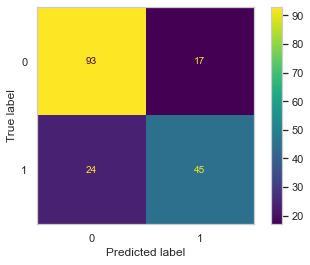

In [50]:
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(lm, X_test, y_test)

## <font color='blue'> 문제 3. 교차검증 3회, RandomgridsearchCV를 적용한 결과, 양성자료 recall의 Optimal test score는?
### <font color='blue'>  ① 0.425 ② 0.545 ③ 0.652  ④ 0.345   ⑤ 0.255

## 5. Randomizedgridsearch with cross validation

- KFold는 3겹 설정하고 KNN 알고리즘과 파이프라인 구성(랜덤시드 11)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (KFold, RandomizedSearchCV)
np.random.seed(11)
kf = KFold(n_splits=3)

steps = [
    ('transformation', ColumnTransformer(transformers=transformer_steps)),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(steps=steps)

In [52]:
params = {'knn__n_neighbors' : list(range(5,105, 4)),
          'knn__weights' : ['uniform','distance'],
          'knn__algorithm': ['ball_tree', 'kd_tree'],
          'knn__leaf_size' : list(range(5,50)),
          'knn__p' : [1, 2]
         }

In [53]:
grid = RandomizedSearchCV(pipe, 
                          param_distributions=params, 
                          cv=kf,
                          n_iter=10, 
                          scoring='recall', verbose=True
                          )
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.7s finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformation',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                                              ('ord',
                                                                               Pipeli

In [54]:
print('optimal train score: {:.3f}'.format(grid.best_score_))
print('optimal test score: {:.3f}'.format(grid.score(X_test, y_test)))
print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.717
optimal test score: 0.652
optimal parameter: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 5, 'knn__leaf_size': 12, 'knn__algorithm': 'kd_tree'}


## <font color='blue'> 문제 4. 아래 문장에서 연구자가 올바르게 예측 한 문장을 모두 고르면 몇 개 인가?
    (1) 이진분류 예측(binary prediction)시, 허위양성 보다 허위음성의 경우가 사회적 비용이 크기 때문에, f2-score를 사용하였다.
    (2) 이진분류 문제에서 가우시안 나이브의 예측 결과는 '0'과 '1'에 편중되는 경향이 있다.
    (3) 예측 알고리즘의 비용함수(cost function)은 모두 동일하다.
    (4) 로지스틱회귀와 의사결정 나무 모형은 과적합되는 경향이 있기 때문에 regularization을 통해 penality를 부여하는 방법을 사용하였다.
    (5) 데이터의 크기와 예측 성능을 보여주는 학습곡선(learning curve)에서 훈련과 검증데이터의 성능 차이가 크다면 High biased 모델이다.
    (6) 불균형데이터에서는 여러 모델을 평가하는 척도로 모델의 정확도(accuracy)보다는 recall과 precesion의 조화평균을 사용하는 것이 바람직하다.
    (7) 앙상블 bagging모델은 여러 weak model을 결합하여 Bias를 줄이게 되어 예측 성능을 높이게 된다.
### <font color='blue'>  ① 1개 ② 2개 ③ 3개 ④ 4개  ⑤ 5개

# Intermission

## <font color='blue'> 문제 5. 주성분과 로지스틱회귀로 예측한 모델의 정확도는 ?
### <font color='blue'>  ① 0.9366 ② 0.9488 ③ 0.9577  ④ 0.9688  ⑤ 0.9877
    * 단 : 자료 표준화는 필요없음
    * PCA(n_components=0.90)로 주성분과 로짓스틱 회귀로 파이프라인을 구성하여 예측하라
    * 교차검증은 3겹으로 한다. (즉 교차검증 후 PCA를 수행한다)

(1797, 64)


<Figure size 432x288 with 0 Axes>

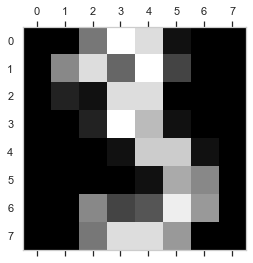

In [25]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[3]) 
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

X = digits['data']
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, RandomizedSearchCV
kf = KFold(n_splits=3)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

steps = [('pca', PCA(n_components=.90)),
         ('clf', LogisticRegression(random_state=42))]

pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('clf', LogisticRegression(random_state=42))])

In [29]:
np.random.seed(42)
params = {'clf__C': np.logspace(-4, 4, 20), 'clf__penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(pipe_lr, param_distributions=params, cv=kf)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('pca', PCA(n_components=0.9)),
                                             ('clf',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'clf__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'clf__penalty': ['l1', 'l2']})

0.9577777777777777

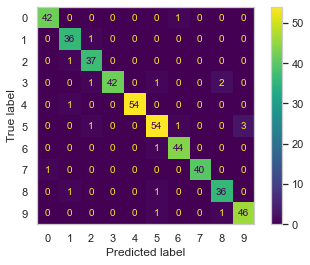

In [30]:
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(grid, X_test, y_test)
y_pred = grid.predict(X_test)
accuracy_score(y_test, y_pred)

# End